In [13]:
import pandas as pd
import os
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
RAW_DATA_PATH = "~/library/data/raw/"
PROC_DATA_PATH = '~/library/data/processed/'

In [36]:
df_1 = pd.read_csv(RAW_DATA_PATH + 'business-survival-rates.csv', sep=',', na_values=[':']) 
df_2 = pd.read_csv(RAW_DATA_PATH + 'Jobs and Job Density.csv', sep=',') 
df_3 = pd.read_csv(RAW_DATA_PATH + 'mb-unemployment-rates.csv', sep=',', na_values=[' ', '-'])

In [37]:
df_1.drop(['births','1_year_survival_number', '1_year_survival_rate', '2_year_survival_number', '2_year_survival_rate', '4_year_survival_number', '4_year_survival_rate' ,'5_year_survival_number', '5_year_survival_rate'], inplace=True, axis=1)

In [38]:
df_1

,code,area,year,3_year_survival_number,3_year_survival_rate
0,E09000001,City of London,2002,760.0,66.4
1,E09000002,Barking and Dagenham,2002,250.0,57.5
2,E09000003,Barnet,2002,1290.0,55.4
3,E09000004,Bexley,2002,470.0,61.4
4,E09000005,Brent,2002,810.0,49.5
5,E09000006,Bromley,2002,825.0,64.5
6,E09000007,Camden,2002,1485.0,57.6
7,E09000008,Croydon,2002,805.0,57.7
8,E09000009,Ealing,2002,1020.0,57.5
9,E09000010,Enfield,2002,685.0,58.5


In [39]:
def replaceCol(df):
    col_length = len(df.columns)
    mapping = {df.columns[0]:'code', df.columns[1]:'area'}
    for index in range(2, col_length):
        if index%2!=0:
            mapping[df.columns[index]] = '+/- Difference'
    return mapping

df_1.dropna(inplace=True, axis=0, how='any')
df_3.dropna(inplace=True, axis=0, how='any')
mapping = replaceCol(df_3)
df_3.rename(columns=mapping, inplace=True)
df_3 = df_3.reset_index(drop=True)
df = pd.merge(df_1, df_2, on=['code','area', 'year'])

In [40]:
def colToDrop(df):
    col_length = len(df.columns)
    arr = []
    for index in range(2, col_length):
        if df.columns[index].find('Jan') != -1:
            if index + 2 < col_length:
                index += 2
            pass
        arr.append(df.columns[index])    
    return arr

df_3.drop(columns=colToDrop(df_3), inplace=True, axis=1)

In [41]:
df_3 = df_3.melt(id_vars=["code", "area"], 
        var_name="Date", 
        value_name="Value")

In [42]:
df_3['Date'] = df_3['Date'].apply(lambda x: [int(s) for s in str.split(x) if s.isdigit()][0])

In [43]:
df_3.rename(columns={'Date':'year', 'Value':'unemployment_rate'}, inplace=True)

In [44]:
df = pd.merge(df, df_3, on=['code','area', 'year'])

In [45]:
df['unemployment_rate'] = df['unemployment_rate'].astype('float')

In [65]:
df.to_csv(PROC_DATA_PATH + "unemployment-and-business-demographics-borough.csv")

In [19]:
boroughs = df['area'].unique().tolist()

shap_arr = []
k2_arr = []
index = 0
for borough in boroughs:
    plt.figure(index)
    index += 1
    stat, p = stats.shapiro(df[df['area'] == borough]['unemployment_rate'])
    #print(len(df[df['area'] == borough]['unemployment_rate']))
    #print()
    plt.scatter()
    #print('Borough=%s, Statistics=%.3f, p=%.3f' % (borough, stat, p))
    # interpret
    alpha = 0.05
    if p <= alpha:
        shap_arr.append((borough, stat, p))
        #print(df[df['area'] == borough]['unemployment_rate'])
        #plt.hist(df[df['area'] == borough]['unemployment_rate'], bins=25)

        print("Shapiro-Wilk's Test not passed (reject H0)", end='\n')
        
    stat, p = stats.normaltest(df[df['area'] == borough]['unemployment_rate'])
    # print('Statistics=%.3f, p=%.3f' % (borough, stat, p))
    # interpret
    #alpha = 0.05
    if p <= alpha:
        k2_arr.append((borough, stat, p))
        print('D’Agostino’s K^2 Test not passed (reject H0)', end='\n')

if len(shap_arr)!= 0:
    print(shap_arr, end='\n')
print()
if len(k2_arr)!= 0:
    print(k2_arr, end='\n')

14

14

14

14

14

14

14

14

14

14

14

Shapiro-Wilk's Test not passed (reject H0)
14

14

14

14

14

14

14

14

14

14

Shapiro-Wilk's Test not passed (reject H0)
14

14

14

14

14

D’Agostino’s K^2 Test not passed (reject H0)
14

14

14

Shapiro-Wilk's Test not passed (reject H0)
14

14

14

14

14

Shapiro-Wilk's Test not passed (reject H0)
D’Agostino’s K^2 Test not passed (reject H0)
14

Shapiro-Wilk's Test not passed (reject H0)
14

Shapiro-Wilk's Test not passed (reject H0)
14

Shapiro-Wilk's Test not passed (reject H0)
14

14

14

Shapiro-Wilk's Test not passed (reject H0)
D’Agostino’s K^2 Test not passed (reject H0)
14

Shapiro-Wilk's Test not passed (reject H0)
D’Agostino’s K^2 Test not passed (reject H0)
14

Shapiro-Wilk's Test not passed (reject H0)
D’Agostino’s K^2 Test not passed (reject H0)
14

14

Shapiro-Wilk's Test not passed (reject H0)
D’Agostino’s K^2 Test not passed (reject H0)
[('Hackney', 0.8298305869102478, 0.011958095245063305), ('Lambeth', 0.86772990226

In [ ]:
df.to_csv(PROC_DATA_PATH + 'borough-unemployment-and-business-data.csv')

In [47]:
df['unemployment_rate'].describe()

count    484.000000
mean       7.607851
std        2.212748
min        3.400000
25%        5.975000
50%        7.500000
75%        9.000000
max       14.200000
Name: unemployment_rate, dtype: float64

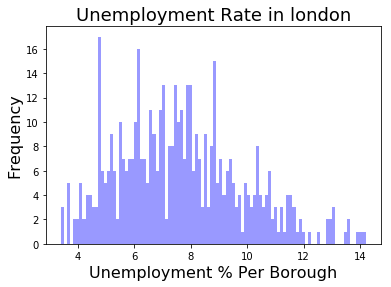

In [64]:
hplot = sns.distplot(df['unemployment_rate'], kde=False, color='blue', bins=100)
plt.title('Unemployment Rate in london', fontsize=18)
plt.xlabel('Unemployment % Per Borough', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plot_file_name="Unemployment_rate_in_london_by_borough.jpg"
hplot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

Text(0.5, 0, 'Unemployment')

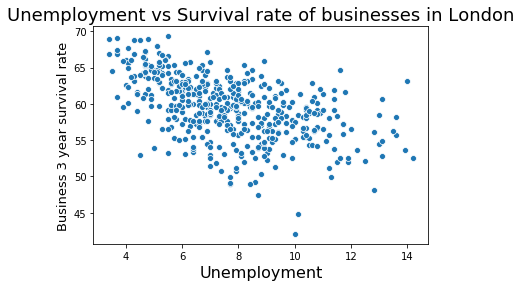

In [52]:
sns.scatterplot('unemployment_rate','3_year_survival_rate',data=df)
plt.title('Unemployment vs Survival rate of businesses in London', fontsize=18)
plt.ylabel('Business 3 year survival rate', fontsize=13)
plt.xlabel('Unemployment', fontsize=16)

Text(0.5, 0, 'Unemployment')

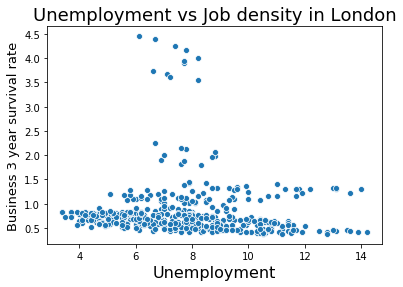

In [61]:
sns.scatterplot('unemployment_rate','job_density',data=df)
plt.title('Unemployment vs Job density in London', fontsize=18)
plt.ylabel('Business 3 year survival rate', fontsize=13)
plt.xlabel('Unemployment', fontsize=16)

In [55]:
df["unemployment_rate_r"] = df['unemployment_rate'].rank()
df["3_year_survival_rate_r"] = df['3_year_survival_rate'].rank()
df['job_density_r'] = df['job_density'].rank()

In [58]:
np.corrcoef(df['unemployment_rate_r'], df['job_density_r'])

array([[ 1.        , -0.24205981],
       [-0.24205981,  1.        ]])

In [59]:
np.corrcoef(df['unemployment_rate_r'], df['3_year_survival_rate_r'])

array([[ 1.        , -0.55911509],
       [-0.55911509,  1.        ]])

In [60]:
stats.spearmanr(df['unemployment_rate_r'],df['3_year_survival_rate_r'])

SpearmanrResult(correlation=-0.5591150921196245, pvalue=3.773637460809197e-41)